<a href="https://colab.research.google.com/github/JoaoPedro8807/computer_vision/blob/main/redes_neuras_classificacao_img_sem_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EXTRAÇÃO DOS DADOS DE IMAGENS PARA ENVIAR PARA REDES NEURAIS (SEM CNN POR ENQUANTO APENAS OS VETORES)**

In [2]:
import cv2
import numpy as np
import os
import zipfile
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



In [3]:
print(tf.__version__)



2.10.0


In [4]:
data_path = './dados/Datasets/homer_bart_1.zip'

zip_object = zipfile.ZipFile(file=data_path, mode='r')
zip_object.extractall('./')
zip_object.close()

In [5]:
root_path = './homer_bart_1'

person_classes = [
  ('homer', 0),
  ('bart', 1)
  ]
arquivos = [os.path.join(root_path, f) for f in os.listdir(root_path)]
type(arquivos)

list

In [ ]:
altura, largura = 128, 128
altura * largura
imagens = []
classes = []


for arquivo in arquivos:
  try:
    imagem = cv2.imread(arquivo, cv2.IMREAD_GRAYSCALE)
    imagem = cv2.resize(imagem, (altura, largura))
  except:
    continue

  #cv2.imshow("Imagem",imagem)
  print(arquivo)
  
  person_name = arquivo.split('/')[-1].split('\\')[-1].split('.')[0]
  person_name = [s for s in person_name if s.isalpha()]
  person_name = ''.join(person_name)
  imagem = imagem.ravel() #transforma a matriz dos pixels em apenas um vetor, para inputar na rede neural

  person_class = 1
  for clazz in person_classes:
    if clazz[0] == person_name:
      person_class = clazz[1]

  classes.append(person_class)
  imagens.append(imagem)

  print(person_name)



In [7]:
X = np.asarray(imagens)
y = np.asarray(classes)

#sns.countplot(x=y)
total_per_person = np.unique(y, return_counts=True)
homer_count, bart_count = total_per_person[1][0], total_per_person[1][1]


# **TRATANDO DADOS E CRIANDO O MODELO**

TRANSFORMA OS VALORES DOS PIXELS DE 255 PARA UM RANGE DE 0 A 1, PARA MELHORAR O PROCESSAMENTO


In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
print(X_scaled.min(), X_scaled.max())

0.0 1.0000000000000002


In [9]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print(f"GPUs disponíveis: {gpus}")
    print(f"TensorFlow está usando GPU: {tf.test.is_gpu_available()}")
else:
    print("Nenhuma GPU encontrada pelo TensorFlow.")

gpus

GPUs disponíveis: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
TensorFlow está usando GPU: True


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [10]:
from sklearn.model_selection import train_test_split

x_treino, x_teste, y_treino, y_teste = train_test_split(X_scaled, y, test_size=0.2, random_state= 1) #garante que os tests e treino serão feitos com os mesmos registros (já separados para test e treino)
x_treino.shape, y_treino.shape
x_teste.shape, y_teste.shape



((54, 16384), (54,))

In [11]:
qtde_total_pixels = int(x_treino.shape[1])
unidades_neuronios = int((qtde_total_pixels + len(person_classes)) / len(person_classes))

network1 = tf.keras.models.Sequential()

network1.add(tf.keras.layers.Input(shape=(qtde_total_pixels,)))
network1.add(tf.keras.layers.Dense(units=unidades_neuronios, activation='relu'))
network1.add(tf.keras.layers.Dense(units=unidades_neuronios, activation='relu'))
network1.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

network1.summary()

#optimizer=adam pq é o padrão para esse tipo de problema simples de 2 classes
#loss function = binary_crossentropy utilizado para calcular erro em modelos de classes binária (esse caso)
network1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = network1.fit(x_treino, y_treino, epochs=100)






Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8193)              134242305 
                                                                 
 dense_1 (Dense)             (None, 8193)              67133442  
                                                                 
 dense_2 (Dense)             (None, 1)                 8194      
                                                                 
Total params: 201,383,941
Trainable params: 201,383,941
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
7/7 [==============================] - 2s 52ms/step - loss: 130.4283 - accuracy: 0.4791
Epoch 2/100
7/7 [==============================] - 0s 45ms/step - loss: 29.3598 - accuracy: 0.4884
Epoch 3/100
7/7 [==============================] - 0s 45ms/step - loss: 5.6096 - accuracy: 0.5814
Epoch 4/1

# **TESTANDO E METRIFICANDO O MODELO**
AGORA USANDO A PARTE DA BASE DE DADOS PARA TESTS




In [12]:
history.history # histórico das 50 epochs

predict1 = network1.predict(x_teste)
# 1 = True (homer)
predict1 = (predict1 > 0.5).astype(bool) # > 0.5 = homer else = bart
x_teste.shape



2/2 [==============================] - 0s 5ms/step


(54, 16384)

accurancy: 0.7037037037037037
confusion matrix: [[17  9]
 [ 7 21]]


<Axes: >

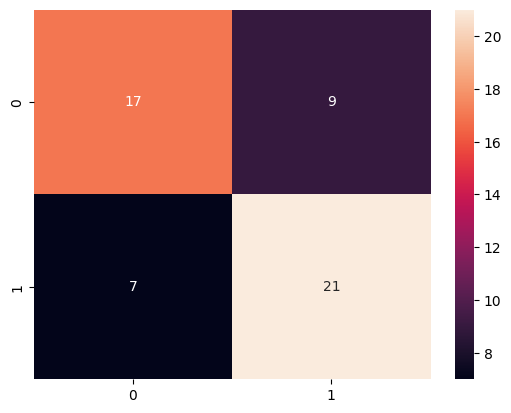

In [13]:
from sklearn.metrics import accuracy_score
accurancy = accuracy_score(predict1, y_teste)
cm = tf.math.confusion_matrix(labels=y_teste, predictions=predict1)
print(f"accurancy: {accurancy}")
print(f"confusion matrix: {cm}")
sns.heatmap(cm, annot=True)




In [14]:
from sklearn.metrics import classification_report
print(classification_report(y_teste, predict1)) #recall = quanto de cada classe ele conseguiu identificar, e precision a precisão dessa identificacao do recall

              precision    recall  f1-score   support

           0       0.71      0.65      0.68        26
           1       0.70      0.75      0.72        28

    accuracy                           0.70        54
   macro avg       0.70      0.70      0.70        54
weighted avg       0.70      0.70      0.70        54



SALVANDO OS DADOS DO TREINAMENTO DO MODELO


In [15]:
model_json = network1.to_json()
with(open('network1.json', 'w') as f):
  f.write(model_json)



SALVA OS PESOS DA REDE NEURAL

In [16]:
from keras.models import save_model
network1.save('network1.keras')

Carregando os arquivos salvos

In [17]:
with(open('network1.json', 'r') as f):
  json_save_model = f.read()

json_save_model

'{"class_name": "Sequential", "config": {"name": "sequential", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 16384], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_1"}}, {"class_name": "Dense", "config": {"name": "dense", "trainable": true, "dtype": "float32", "units": 8193, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Dense", "config": {"name": "dense_1", "trainable": true, "dtype": "float32", "units": 8193, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity

In [18]:
network1_loaded = tf.keras.models.model_from_json(json_save_model)
network1_loaded.load_weights('network1.keras')
network1_loaded.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']  )


In [19]:
network1_loaded.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8193)              134242305 
                                                                 
 dense_1 (Dense)             (None, 8193)              67133442  
                                                                 
 dense_2 (Dense)             (None, 1)                 8194      
                                                                 
Total params: 201,383,941
Trainable params: 201,383,941
Non-trainable params: 0
_________________________________________________________________


IMPORTANDO O TREINAMENTO E O PESO DE UM .KERAS (MAIS RECOMENDADO)

In [20]:
import tensorflow as tf
network1_loaded_from_keras = tf.keras.models.load_model('network1.keras')
network1_loaded_from_keras.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
network1_loaded_from_keras.summary()



InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

CLASSIFICAÇÃO DE UNICA IMG
  

In [21]:
img_index = 7
img1 = x_teste[img_index]
img1 = scaler.inverse_transform(img1.reshape(1, -1))
cv2.imshow('img', img1.reshape(128, 128))
predict = network1.predict(img1)[0][0]
int_class = np.round(predict)
for p in person_classes:
  if p[1] == int_class:
    print(p[0])


1/1 [==============================] - 0s 32ms/step
homer


# **EXTRAÇÃO DE CARACTERÍSITCAS DA IMAGEM**

In [ ]:
arquivos = [os.path.join(root_path, f) for f in sorted(os.listdir(root_path))]
export = 'boca, calca, sapatos, camisa, calcao, tenis, classe\n'
mostrar_img  = False
caracteristicas = []

for arqv in arquivos:
  try:
    img_original = cv2.imread(arqv)
    (H, W) = img_original.shape[:2]
  except:
    continue

  img_alterada = img_original.copy()
  img_caracteristicas = []
  img_nome =  os.path.basename(os.path.normpath(arqv))
  if img_nome.startswith('h'):
    classe = 0 #homer
  else:
    classe = 1 #bart
  boca, calca, sapato, camisa, calcao, tenis = 0, 0, 0, 0, 0, 0
  for altura in range(0, H):
    for largura in range(0, W):
    # RGB -> BGR
      azul = img_alterada.item(altura, largura, 0)
      verde = img_alterada.item(altura, largura, 1)
      vermelho = img_alterada.item(altura, largura, 2)

      # Homer - marrom da boca
      if (azul >= 95 and azul <= 140 and verde >= 160 and verde <= 185 and vermelho >= 175 and vermelho <= 205):
        img_alterada[altura, largura] = [0, 255, 255]
        boca += 1

      # Homer - azul da calça
      if (azul >= 150 and azul <= 180 and verde >= 98 and verde <= 120 and vermelho >= 0 and vermelho <= 90):
        img_alterada[altura, largura] = [0, 255, 255]
        calca += 1

      # Homer - cinza dos sapatos
      if altura > (H / 2):
        if (azul >= 25 and azul <= 45 and verde >= 25 and verde <= 45 and vermelho >= 25 and vermelho <= 45):
          img_alterada[altura, largura] = [0, 255, 255]
          sapato += 1

      # Bart - laranja da camisa
      if (azul >= 11 and azul <= 50 and verde >= 85 and verde <= 105 and vermelho >= 240 and vermelho <= 255):
        img_alterada[altura, largura] = [0, 255, 128]
        camisa += 1

      # Bart - azul do calção
      if (azul >= 125 and azul <= 170 and verde >= 0 and verde <= 12 and vermelho >= 0 and vermelho <= 20):
        img_alterada[altura, largura] = [0, 255, 128]
        calcao += 1

      # Bart - azul do tênis
      if altura > (H / 2):
        if (azul >= 125 and azul <= 170 and verde >= 0 and verde <= 12 and vermelho >= 0 and vermelho <= 20):
          img_alterada[altura, largura] = [0, 255, 128]
          tenis += 1

  boca = round((boca / (H * W)) * 100, 9)
  calca = round((boca / (H * W)) * 100, 9)
  sapato = round((boca / (H * W)) * 100, 9)
  camisa = round((camisa / (H * W)) * 100, 9)
  calcao = round((calcao / (H * W)) * 100, 9)
  tenis = round((tenis / (H * W)) * 100, 9)

  img_caracteristicas.append(boca)
  img_caracteristicas.append(calca)
  img_caracteristicas.append(sapato)
  img_caracteristicas.append(camisa)
  img_caracteristicas.append(calcao)
  img_caracteristicas.append(tenis)
  img_caracteristicas.append(classe)
  caracteristicas.append(img_caracteristicas)

  #print(f"VALOR HOMER BOCA: {img_caracteristicas[0]}\n VALOR HOMER CALCA: {img_caracteristicas[1]}\n VALOR SAPATO: {img_caracteristicas[2]}", )

  f = ','.join([str(c) for c in img_caracteristicas])
  export += f + '\n'
  if mostrar_img:
    img_alterada = cv2.cvtColor(img_alterada, cv2.COLOR_BGR2RGB)
    img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(img_original)
    plt.subplot(1, 2, 2)
    plt.imshow(img_alterada)
    plt.show()





In [25]:
export
with open('features.csv', 'w') as f:
    f.write(export)
f.close()



In [ ]:
ds = pd.read_csv('features.csv')
ds.head()

In [ ]:
X = ds.iloc[:, :-1].values #caracteristicas
y = ds.iloc[:, -1].values #rotulos
len(X), len(y)


array([0.        , 0.        , 0.        , 6.88610189, 3.49520435,
       3.49520435])

In [ ]:
# separação 70% treino / 30% teste (mantendo distribuição de classes com stratify)
x_treino, x_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# normaliza características (MinMax 0-1)
scaler_features = MinMaxScaler()
x_treino = scaler_features.fit_transform(x_treino)
x_teste = scaler_features.transform(x_teste)

# verificações rápidas
print("shapes:", x_treino.shape, x_teste.shape, y_treino.shape, y_teste.shape)
print("train distribution:", np.unique(y_treino, return_counts=True))
print("test distribution:", np.unique(y_teste, return_counts=True))
x_treino[0]

In [ ]:
network2 = tf.keras.models.Sequential()

network2.add(tf.keras.layers.Input(shape=(x_treino.shape[1], )))  
network2.add(tf.keras.layers.Dense(units=16, activation='relu'))
network2.add(tf.keras.layers.Dense(units=8, activation='relu'))
network2.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

network2.summary()
network2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history2 = network2.fit(x_treino, y_treino, epochs=100)

In [68]:
predict2 = network2.predict(x_teste)
predict2 = (predict2 > 0.5).astype(bool)
predict2

3/3 [==============================] - 0s 3ms/step


array([[ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [

In [69]:
from sklearn.metrics import accuracy_score
accurancy = accuracy_score(predict2, y_teste)
accurancy

0.8271604938271605